In [1]:
import numpy as np

import dreamcoder as dc
from dreamcoder.domains.quantum_algorithms.primitives import *
from dreamcoder.domains.quantum_algorithms.tasks import *

import time
from tqdm import trange
import random

%autoreload 2
%load_ext line_profiler

### Testing some circuits

In [2]:

n_qubit = 2
full_circuit = (n_qubit,
           (("cnot", 0, 1),
           ("swap", 0, 1),
           ("hadamard", 1))
)

In [3]:
tensor = eye(n_qubit)
tensor_to_mat(swap(cnot(tensor,0,1),0,1))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float16)

In [4]:
full_circuit

(2, (('cnot', 0, 1), ('swap', 0, 1), ('hadamard', 1)))

In [23]:
full_circuit_to_mat(full_circuit)

array([[ 0.707,  0.707,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.707,  0.707],
       [ 0.   ,  0.   ,  0.707, -0.707],
       [ 0.707, -0.707,  0.   ,  0.   ]], dtype=float16)

In [24]:
print_circuit(full_circuit)

                  
q_0: ──■───X──────
     ┌─┴─┐ │ ┌───┐
q_1: ┤ X ├─X─┤ H ├
     └───┘   └───┘


In [25]:
with QiskitTester(full_circuit) as QT:
    QT.circuit.cnot(QT.q(0),QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
print(QT)
QT.check()

     ┌───┐   ┌───┐
q_0: ┤ X ├─X─┤ H ├
     └─┬─┘ │ └───┘
q_1: ──■───X──────
                  


Code consistent with Qiskit


In [26]:
n_qubit= 3
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
code.infer()
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [27]:
code.evaluate([])(no_op(n_qubit))

((1, -1, 3), (('cnot', 1, 0),))

In [28]:
state_circuit_to_mat(code.evaluate([])(no_op(n_qubit)))

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float16)

### Testing some Tasks

In [5]:
tasks = makeTasks()

In [30]:
task = get_task_from_name("hadamard_0",tasks)
code = dc.program.Program.parse("(lambda (h $0))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -3.8918202981106265)

In [31]:
task =get_task_from_name("cnot_01",tasks)
code = dc.program.Program.parse("(lambda (cnot $0))")
task.logLikelihood(code), grammar.logLikelihood(code.infer(), code)

(0.0, -3.8918202981106265)

In [32]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv $0))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -7.783640596221253)

In [33]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot $0))))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.567281192442506)

In [34]:
task = get_task_from_name("cz_01",tasks)
code = dc.program.Program.parse("(lambda (h(mv(cnot(mv_r(h (mv $0)))))))")
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)
np.round(state_circuit_to_mat(code.evaluate([])(no_op(2))),decimals=2)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -1.]], dtype=float16)

In [35]:
with QiskitTester(code.evaluate([])(no_op(3))) as QT:
    QT.circuit.cz(QT.q(0),QT.q(1))
print(QT)
QT.check()
np.real(np.array(QT.result))

        
q_0: ───
        
q_1: ─■─
      │ 
q_2: ─■─
        


Code consistent with Qiskit


array([[ 1.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.]])

In [36]:
with QiskitTester(code.evaluate([])(no_op(2))) as QT:
    QT.circuit.cz(QT.q(1),QT.q(0))
print(QT)
np.real(np.array(QT.result))

        
q_0: ─■─
      │ 
q_1: ─■─
        


array([[ 1.,  0.,  0., -0.],
       [ 0.,  1.,  0., -0.],
       [ 0.,  0.,  1., -0.],
       [ 0.,  0.,  0., -1.]])

In [37]:
task = get_task_from_name("cnot_nn_1",tasks)
code = dc.program.Program.parse("(lambda (cnot ((rep (dec(dec(size $0))) (lambda (mv $0))) $0)))")
code.evaluate([])(no_op(3))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(0.0, -15.83434397769155)

In [38]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) ) $0 )))))")
print_circuit(code.evaluate([])(no_op(3)))
task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

          ┌───┐                         ┌───┐     
q_0: ──■──┤ X ├──■───────────────────■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├
     └───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐└───┘     └───┘
q_2: ───────────────┤ X ├──■──┤ X ├───────────────
                    └───┘     └───┘               


(0.0, -53.633315382926966)

In [39]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) ) $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

In [40]:
## If swap was included
# task = get_task_from_name("swap_0n",tasks)
# code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda (swap(mv_r $0))) )  (mv_r( (rep (dec(size $0)) (lambda (mv(swap $0))) )  $0 )))))")
# print_circuit(code.evaluate([])(no_op(5)))
# task.logLikelihood(code),  grammar.logLikelihood(code.infer(), code)

### Profile bottom-up enumeration

In [13]:
try:
    import binutil  # required to import from dreamcoder modules
except ModuleNotFoundError:
    import bin.binutil  # alt import if called as module

from dreamcoder.domains.quantum_algorithms.main import main
from dreamcoder.dreamcoder import commandlineArguments
from dreamcoder.utilities import numberOfCPUs

arguments = commandlineArguments(
    featureExtractor=None, # it was TowerCNN
    CPUs=numberOfCPUs(),
    helmholtzRatio=0.5,
    recognitionTimeout=6,
    iterations=6,
    a=3,
    structurePenalty=1,
    pseudoCounts=10,
    topK=2,
    maximumFrontier=5,
    extras=None,
    solver="bottom", 
    useRecognitionModel=False,
    enumerationTimeout=6,#-g
    compressor="pypy")   #ocaml, python, pypy  


CUDA is available?: False
using cuda?: False


usage: ipykernel_launcher.py [-h] [--resume RESUME] [-i ITERATIONS]
                             [-t ENUMERATIONTIMEOUT] [-R RECOGNITIONTIMEOUT]
                             [-RS RECOGNITIONSTEPS] [-k TOPK]
                             [-p PSEUDOCOUNTS] [-b AIC] [-l STRUCTUREPENALTY]
                             [-a ARITY] [-c CPUS] [--no-cuda]
                             [-m MAXIMUMFRONTIER] [--reuseRecognition]
                             [--recognition] [--ensembleSize ENSEMBLESIZE]
                             [-g] [-d] [--no-consolidation]
                             [--testingTimeout TESTINGTIMEOUT]
                             [--testEvery TESTEVERY] [--seed SEED]
                             [--activation {relu,sigmoid,tanh}]
                             [--solver {ocaml,pypy,bottom,python}]
                             [-r HELMHOLTZRATIO]
                             [--compressor {pypy,rust,vs,pypy_vs,ocaml,memorize}]
                             [--matrixRank MATRIXRANK] 

In [14]:
# %lprun -f dc.domains.quantum_algorithms.primitives.tensor_contraction -f dc.domains.quantum_algorithms.tasks.QuantumTask.logLikelihood -f dc.domains.quantum_algorithms.primitives.execute_quantum_algorithm -f full_circuit_to_mat -f dc.enumeration.multicoreEnumeration main(arguments)
main(arguments)

Running EC on 01-mar-grp-0020 @ 2022-04-03 20:06:17.653038 with 8 CPUs and parameters:
	 noConsolidation  =  False
	 iterations  =  6
	 enumerationTimeout  =  6
	 useRecognitionModel  =  False
	 topk_use_only_likelihood  =  False
	 pseudoCounts  =  10
	 aic  =  1.0
	 structurePenalty  =  1
	 arity  =  3
	 taskReranker  =  default
	 storeTaskMetrics  =  True
	 rewriteTaskMetrics  =  False
	 maximumFrontier  =  5
	 solver  =  bottom
	 topK  =  2
	 evaluationTimeout  =  0.01
	 cuda  =  False

Currently using this much memory: 208424960
Currently using this much memory: 208429056
Using a waking task batch of size: 19
Disabling parallelism on the Python side because we only have one job.
If you are using ocaml or bottom, there could still be parallelism.
(frontend) Launching int -> tcircuit (19 tasks) w/ 8 CPUs. 0.000000 <= MDL < 6.000000. Timeout 6.000000.
PANIC! Exception in child worker: [Errno 2] No such file or directory: 'pypy3': 'pypy3'
Traceback (most recent call last):
  File "/Use

AssertionError: 

In [43]:
code = dc.program.Program.parse("(lambda ((rep (inc(inc(dec 0))) (lambda (mv $0))) $0))")
code.evaluate([])(no_op(5))
code.infer()
tasks[0].logLikelihood(code),  grammar.logLikelihood(code.infer(), code)


(-inf, -13.328818040700815)

## Recognition model

In [44]:
print(grammar)

continuation : tcircuit
0.000000	t0	$_
0.000000	tcircuit -> tcircuit	mv
0.000000	tcircuit -> tcircuit	mv_r
0.000000	tcircuit -> tcircuit	minv
0.000000	tcircuit -> tcircuit	h
0.000000	tcircuit -> tcircuit	cnot
0.000000	int -> (tcircuit -> tcircuit) -> tcircuit -> tcircuit	rep
0.000000	int	0
0.000000	int -> int	inc
0.000000	int -> int	dec
0.000000	tcircuit -> int	size


In [6]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))

pcfg compilation: distinct non terminals 2 ; distinct environments 2
pcfg compilation: distinct non terminals 2 ; distinct environments 2


In [46]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=False)

In [47]:
for i in range(200):
    print(next(iterator))

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4


(lambda $0)


 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8


(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))


 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12


(lambda (mv (mv $0)))
(lambda (mv (mv_r $0)))
(lambda (mv (minv $0)))
(lambda (mv (h $0)))
(lambda (mv (cnot $0)))
(lambda (mv_r (mv $0)))
(lambda (mv_r (mv_r $0)))
(lambda (mv_r (minv $0)))
(lambda (mv_r (h $0)))
(lambda (mv_r (cnot $0)))
(lambda (minv (mv $0)))
(lambda (minv (mv_r $0)))
(lambda (minv (minv $0)))
(lambda (minv (h $0)))
(lambda (minv (cnot $0)))
(lambda (h (mv $0)))
(lambda (h (mv_r $0)))
(lambda (h (minv $0)))
(lambda (h (h $0)))
(lambda (h (cnot $0)))
(lambda (cnot (mv $0)))
(lambda (cnot (mv_r $0)))
(lambda (cnot (minv $0)))
(lambda (cnot (h $0)))
(lambda (cnot (cnot $0)))


 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15


(lambda (rep 0 (lambda $0) $0))


 -- Bottom up enumeration, cost 16


(lambda (mv (mv (mv $0))))
(lambda (mv (mv (mv_r $0))))
(lambda (mv (mv (minv $0))))
(lambda (mv (mv (h $0))))
(lambda (mv (mv (cnot $0))))
(lambda (mv (mv_r (mv $0))))
(lambda (mv (mv_r (mv_r $0))))
(lambda (mv (mv_r (minv $0))))
(lambda (mv (mv_r (h $0))))
(lambda (mv (mv_r (cnot $0))))
(lambda (mv (minv (mv $0))))
(lambda (mv (minv (mv_r $0))))
(lambda (mv (minv (minv $0))))
(lambda (mv (minv (h $0))))
(lambda (mv (minv (cnot $0))))
(lambda (mv (h (mv $0))))
(lambda (mv (h (mv_r $0))))
(lambda (mv (h (minv $0))))
(lambda (mv (h (h $0))))
(lambda (mv (h (cnot $0))))
(lambda (mv (cnot (mv $0))))
(lambda (mv (cnot (mv_r $0))))
(lambda (mv (cnot (minv $0))))
(lambda (mv (cnot (h $0))))
(lambda (mv (cnot (cnot $0))))
(lambda (mv_r (mv (mv $0))))
(lambda (mv_r (mv (mv_r $0))))
(lambda (mv_r (mv (minv $0))))
(lambda (mv_r (mv (h $0))))
(lambda (mv_r (mv (cnot $0))))
(lambda (mv_r (mv_r (mv $0))))
(lambda (mv_r (mv_r (mv_r $0))))
(lambda (mv_r (mv_r (minv $0))))
(lambda (mv_r (mv_r (h $0)))

 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18


(lambda (rep (inc 0) (lambda $0) $0))
(lambda (rep (dec 0) (lambda $0) $0))


 -- Bottom up enumeration, cost 19


(lambda (mv (rep 0 (lambda $0) $0)))
(lambda (mv_r (rep 0 (lambda $0) $0)))
(lambda (minv (rep 0 (lambda $0) $0)))
(lambda (h (rep 0 (lambda $0) $0)))
(lambda (cnot (rep 0 (lambda $0) $0)))
(lambda (rep 0 (lambda $0) (mv $0)))
(lambda (rep 0 (lambda $0) (mv_r $0)))
(lambda (rep 0 (lambda $0) (minv $0)))
(lambda (rep 0 (lambda $0) (h $0)))
(lambda (rep 0 (lambda $0) (cnot $0)))
(lambda (rep 0 (lambda (mv $0)) $0))
(lambda (rep 0 (lambda (mv_r $0)) $0))
(lambda (rep 0 (lambda (minv $0)) $0))
(lambda (rep 0 (lambda (h $0)) $0))
(lambda (rep 0 (lambda (cnot $0)) $0))
(lambda (rep (size $0) (lambda $0) $0))


 -- Bottom up enumeration, cost 20


(lambda (mv (mv (mv (mv $0)))))
(lambda (mv (mv (mv (mv_r $0)))))
(lambda (mv (mv (mv (minv $0)))))
(lambda (mv (mv (mv (h $0)))))
(lambda (mv (mv (mv (cnot $0)))))
(lambda (mv (mv (mv_r (mv $0)))))
(lambda (mv (mv (mv_r (mv_r $0)))))
(lambda (mv (mv (mv_r (minv $0)))))
(lambda (mv (mv (mv_r (h $0)))))
(lambda (mv (mv (mv_r (cnot $0)))))
(lambda (mv (mv (minv (mv $0)))))
(lambda (mv (mv (minv (mv_r $0)))))
(lambda (mv (mv (minv (minv $0)))))
(lambda (mv (mv (minv (h $0)))))
(lambda (mv (mv (minv (cnot $0)))))
(lambda (mv (mv (h (mv $0)))))
(lambda (mv (mv (h (mv_r $0)))))
(lambda (mv (mv (h (minv $0)))))
(lambda (mv (mv (h (h $0)))))
(lambda (mv (mv (h (cnot $0)))))
(lambda (mv (mv (cnot (mv $0)))))
(lambda (mv (mv (cnot (mv_r $0)))))
(lambda (mv (mv (cnot (minv $0)))))
(lambda (mv (mv (cnot (h $0)))))
(lambda (mv (mv (cnot (cnot $0)))))


In [48]:
dc.program.Program.parse("(lambda (mv (h (h  $0))))").evaluate([])(no_op(3))

([1, 1, 3], (('hadamard', 0), ('hadamard', 0)))

In [7]:
iterator = restricted_pcfg.quantized_enumeration(observational_equivalence=True,
                                                 inputs=[[no_op(3)],[no_op(4)]], 
                                                 sound=False)

In [8]:
for i in range(200): 
    print(next(iterator))

[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
(lambda $0)


 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
(lambda (mv $0))
(lambda (mv_r $0))
(lambda (minv $0))
(lambda (h $0))
(lambda (cnot $0))


 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]


 -- Bottom up enumeration, cost 12


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4)

 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]


 -- Bottom up enumeration, cost 15


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]


 -- Bottom up enumeration, cost 16


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3)

 -- Bottom up enumeration, cost 17


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]


 -- Bottom up enumeration, cost 18


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]


 -- Bottom up enumeration, cost 19


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]


 -- Bottom up enumeration, cost 20


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4)

 -- Bottom up enumeration, cost 21


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]


 -- Bottom up enumeration, cost 22


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3)

 -- Bottom up enumeration, cost 23


() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3)

 -- Bottom up enumeration, cost 24


() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 4), ())], [((0, 1, 3), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4), ())]]
() [[((0, 1, 3), ())], [((0, 1, 4)

In [9]:
print(restricted_pcfg)

start symbol: (tcircuit, (tcircuit,))

(tcircuit, (tcircuit,)) ::= mv	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= mv_r	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= minv	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= h	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= cnot	0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= rep	0x(int, (tcircuit,)) 1x(tcircuit, (tcircuit,)) 0x(tcircuit, (tcircuit,))		-1.9459101490553132
(tcircuit, (tcircuit,)) ::= $0			-1.9459101490553132

(int, (tcircuit,)) ::= 0			-1.3862943611198906
(int, (tcircuit,)) ::= inc	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= dec	0x(int, (tcircuit,))		-1.3862943611198906
(int, (tcircuit,)) ::= size	0x(tcircuit, (tcircuit,))		-1.3862943611198906


In [13]:
sloppy =dc.sloppy.Sloppy(inputs=[[no_op(3)],[no_op(4)]],n=5,sound=True)

In [14]:
dc.program.Program.parse("$0")

$0

In [15]:
sloppy.compute_signature(dc.program.Program.parse("$0"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,)))

(((0, 1, 3),
  b'\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<'),
 ((0, 1, 4),
  b'\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [18]:
sloppy.compute_signature(dc.program.Program.parse("(rep (inc 0) (lambda $0) $0)"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,))) == sloppy.compute_signature(dc.program.Program.parse("$0"), 
                         tp=dc.domains.quantum_algorithms.primitives.tcircuit,
                         arguments=((dc.domains.quantum_algorithms.primitives.tcircuit,)))

True

In [10]:
restricted_pcfg = dc.grammar.PCFG.from_grammar(grammar, request=dc.type.arrow(tcircuit, tcircuit))
restricted_dictionary = dc.enumeration.enumerate_pcfg(restricted_pcfg,timeout=6, 
                                                      circuit_execution_function=state_circuit_to_mat,no_op=no_op,
                                                      observational_equivalence=True,)

pcfg compilation: distinct non terminals 2 ; distinct environments 2
[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4
 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8
 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12
 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15
 -- Bottom up enumeration, cost 16
 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18
 -- Bottom up enumeration, cost 19
 -- Bottom up enumeration, cost 20
 -- Bottom up enumeration, cost 21
 -- Bottom up enumeration, cost 22
 -- Bottom up enumeration, cost 23
 -- Bottom up enumeration, cost 24
 -- Bottom up enumeration, cost 25
 -- Bottom up enum

In [11]:
full_pcfg = dc.grammar.PCFG.from_grammar(full_grammar, request=dc.type.arrow(tcircuit_full, tcircuit_full))
full_dictionary = dc.enumeration.enumerate_pcfg(full_pcfg,
                                                timeout=6, 
                                                circuit_execution_function=full_circuit_to_mat,
                                                no_op=f_no_op,
                                                observational_equivalence=True,
                                                sound=False)

pcfg compilation: distinct non terminals 2 ; distinct environments 2
[(lambda 0)]
 -- Bottom up enumeration, cost 0
 -- Bottom up enumeration, cost 1
 -- Bottom up enumeration, cost 2
 -- Bottom up enumeration, cost 3
 -- Bottom up enumeration, cost 4
 -- Bottom up enumeration, cost 5
 -- Bottom up enumeration, cost 6
 -- Bottom up enumeration, cost 7
 -- Bottom up enumeration, cost 8
 -- Bottom up enumeration, cost 9
 -- Bottom up enumeration, cost 10
 -- Bottom up enumeration, cost 11
 -- Bottom up enumeration, cost 12
 -- Bottom up enumeration, cost 13
 -- Bottom up enumeration, cost 14
 -- Bottom up enumeration, cost 15
 -- Bottom up enumeration, cost 16
 -- Bottom up enumeration, cost 17
 -- Bottom up enumeration, cost 18
 -- Bottom up enumeration, cost 19
 -- Bottom up enumeration, cost 20
 -- Bottom up enumeration, cost 21
 -- Bottom up enumeration, cost 22
 -- Bottom up enumeration, cost 23
 -- Bottom up enumeration, cost 24
 -- Bottom up enumeration, cost 25
 -- Bottom up enum

In [13]:
matched_programs = []
for unitary in full_dictionary.keys():
    if unitary in restricted_dictionary.keys():
        try:
            full_task = full_dictionary[unitary]["task"]
            full_unitary = full_circuit_to_mat(dc.program.Program.parse(full_task).evaluate([])(f_no_op(4)))
            
            restricted_task = restricted_dictionary[unitary]["task"]
            restricted_unitary = state_circuit_to_mat(dc.program.Program.parse(restricted_task).evaluate([])(no_op(4)))

            if np.all(full_unitary==restricted_unitary):
                matched_programs.append([full_task, 
                                         restricted_task, 
                                         max(full_dictionary[unitary]["time"],restricted_dictionary[unitary]["time"])])
        except QuantumCircuitException:
            ...
eprint(f"Enumerated {len(matched_programs)} programs")
# how long it took to enumerate (when the program was found)

Enumerated 243 programs


In [23]:
def merge_two_programs(str_e1, str_e2):
    e1 = dc.program.Program.parse(str_e1)
    e2 = dc.program.Program.parse(str_e2)
    
    return dc.program.Abstraction(
        dc.program.Application(e1,
        dc.program.Application(e2, dc.program.Index(0)))
    ).betaNormalForm(reduceInventions=False)



(3,
 (('cnot', 1, 0),
  ('hadamard', 0),
  ('cnot', 1, 0),
  ('cnot', 0, 1),
  ('cnot', 0, 1),
  ('cnot', 1, 0),
  ('hadamard', 0),
  ('cnot', 0, 1)))

In [41]:
for i in range(len(matched_programs)):
    for j in range(len(matched_programs)):
        e1 = dc.program.Program.parse(matched_programs[-1][0])
        e2 = dc.program.Program.parse(matched_programs[-10][0])

        merge_two_programs(matched_programs[i][0], matched_programs[j][0])#.evaluate([])(f_no_op(3))


Save/Load

In [5]:
import pickle
import os
save_path = os.path.join("experimentOutputs/quantum/","matched_programs")

In [19]:
with open(save_path,"wb") as f:
    pickle.dump(matched_programs, f)
    
with open(save_path+"_restricted","wb") as f:
    pickle.dump(restricted_dictionary, f)
    
with open(save_path+"_full","wb") as f:
    pickle.dump(full_dictionary, f)

In [6]:
with open(save_path,"rb") as f:
        matched_programs = pickle.load(f)
        
with open(save_path+"_restricted","rb") as f:
        restricted_dictionary = pickle.load(f)
        
with open(save_path+"_full","rb") as f:
        full_dictionary = pickle.load(f)
        
        
print(f"Opened file with {len(matched_programs)} matched programs")

Opened file with 1466 matched programs


In [16]:
len(full_dictionary)

988062

In [17]:
len(restricted_dictionary)

40556

### Feature Extractors for Recognition Network


In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import dreamcoder.great

#### Bag of words Feature Extractor

In [25]:
class BagOfWordsFeatureExtractor(nn.Module):
    def __init__(self, tasks, full_op_names): # why do we need tasks?
        super(BagOfWordsFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = self.len_names*self.qubit_num
        self.tasks=tasks
        
    # full_circuit to embedding (bag of words)
    def full_circuit_to_embedding(self, full_circuit):
        embedding = np.zeros([self.len_names], dtype=int)
        for operation in full_circuit:
            embedding[self.names.index(operation[0])]+=1
        return embedding

    def full_task_to_embedding(self,full_task):
        full_embedding = np.hstack(
            [self.full_circuit_to_embedding(full_task.target_algorithm(n_qubit)[1]) 
             for n_qubit in range(self.qubit_test_range[0],self.qubit_test_range[1]+1)]
            )
        return full_embedding
    
    def featuresOfTask(self, t):
        return dc.recognition.variable(self.full_task_to_embedding(t)).float()
    def featuresOfTasks(self, ts):
        return dc.recognition.variable([self.full_task_to_embedding(t) for t in ts]).float()
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

#### GREAT feature for recognition model

In [345]:
class GreatFeatureExtractor(nn.Module):
    
    def __init__(self, tasks, full_op_names, d_model): # why do we need tasks?
        super(GreatFeatureExtractor, self).__init__()
        self.recomputeTasks = False
        
        self.qubit_test_range = [3,5]
        self.qubit_num = self.qubit_test_range[1]-self.qubit_test_range[0]+1
        
        self.names = list(full_op_names.keys())
        self.len_names =len(self.names)
        
        self.outputDimensionality = d_model
        self.tasks=tasks
        
        self.feature_extr = dc.great.Great(layers=4, d_model=self.outputDimensionality, batch_first=True)
        
        n_qubits = 4 ## HARD-CODED, should be changed
        
        # make list of lexicons (possible gate names)
        self.vertex_lexicon = list(full_op_names.keys()) + ["input"]
        # define embedding network for the lexicons
        self.vertex_lexicon_embedding = nn.Embedding(len(self.vertex_lexicon), self.outputDimensionality)
        # define embedding network for the input type numbers
        self.vertex_kind_embedding = nn.Embedding(n_qubits, self.outputDimensionality)


        # make edge lexicon list
        self.edge_lexicon = sorted(["nothing", "input", "io", "output"])
        # define embedding network for lexicon
        self.edge_lexicon_embedding = nn.Embedding(len(self.edge_lexicon), self.outputDimensionality)

        # define many embedding neural networks for the node id
        self.max_gate_size = 2
        self.edge_kind_embeddings = [nn.Embedding(self.max_gate_size, self.outputDimensionality),
                                     nn.Embedding(self.max_gate_size, self.outputDimensionality)]
        # define the no_relation tensor
        self.edge_no_relation = self.edge_lexicon.index("nothing")

    # define total embedding
    def get_vertex_list_embedding(self,vertex_list):
        gate_indices = []
        kind_indices = []
        for vertex in vertex_list:
            gate, kind = vertex[1].split("_")

            gate_indices.append(self.vertex_lexicon.index(gate))
            kind_indices.append(int(kind))

        vertex_embedding = self.vertex_lexicon_embedding(torch.tensor(gate_indices)) + self.vertex_kind_embedding(torch.tensor(kind_indices))
        return vertex_embedding

    def get_edge_list_embedding(self, edges, vertices):
        
        # put correct relations where they exist
        edge_np_embedding = np.full([len(vertices),
                                    len(vertices)],
                                    self.edge_no_relation)

        edge_embedding = self.edge_lexicon_embedding(torch.tensor(edge_np_embedding))

        for edge in edges:
            edge_parts = edge[0].split("_")
            
            edge_type = self.edge_lexicon.index(edge_parts[0])
            edge_type_embedding = self.edge_lexicon_embedding(torch.tensor(edge_type))
            
            edge_kinds = [int(part) for part in edge_parts[1:]]
            edge_kinds_embedding = [self.edge_kind_embeddings[kind_index](torch.tensor(kind))
                                    for kind_index,kind in enumerate(edge_kinds)]
            
            edge_embedding[edge_kinds[0], edge_kinds[1]] = edge_type_embedding + sum(edge_kinds_embedding)
        return edge_embedding

    def add_vertex(self,type, vertices):
        idx = len(vertices) 
        vertices.add((idx, type))
        return idx

    def get_initial_bindings(self,n_bindings, vertices):
        return {i:self.add_vertex(f"input_{i}", vertices) for i in range(n_bindings)}

    def get_relations(self,changed_vertices):
        relations = []
        changed_vertices_array = np.array(changed_vertices)
        
        # among inputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((f"input_{i}_{j}", changed_vertices_array[i][0], changed_vertices_array[j][0]) )
        
        # among outputs
        for i in range(len(changed_vertices_array)):
            for j in range(i+1, len(changed_vertices_array)):
                relations.append((f"output_{i}_{j}", changed_vertices_array[i][1], changed_vertices_array[j][1] ))
        
        # input - output
        for i in range(len(changed_vertices_array)):
            for j in range(len(changed_vertices_array)):
                relations.append((f"io_{i}_{j}", changed_vertices_array[i][0], changed_vertices_array[j][1]))
        
        return relations

    def get_graph(self, circuit, bindings, vertices, edges):
        if len(circuit)>0:
            current_op = circuit[0]
            new_bindings = bindings.copy()
            changed_vertices = []
            for idx, i in enumerate(current_op[1:]):
                new_bindings[i] = self.add_vertex(f"{current_op[0]}_{idx}", vertices)  # CHANGE TO INPUT LEFT/RIGHT
                changed_vertices.append([bindings[i], new_bindings[i]])
                
            relations = self.get_relations(changed_vertices)
            edges.update(relations)
            self.get_graph(circuit[1:], new_bindings, vertices, edges)
            
    def full_circuit_to_embedding(self, full_circuit):
        n_qubits, circuit = full_circuit
        
        vertices = set()
        edges = set()
        bindings = self.get_initial_bindings(n_qubits, vertices)
        self.get_graph(circuit, bindings, vertices, edges)
        
        # make vertex list
        # sort it
        vertex_list = sorted(list(vertices), key=lambda vertex: vertex[0])
        vertex_embedding = self.get_vertex_list_embedding(vertex_list)
        
        # make edges embedding
        edge_embedding = self.get_edge_list_embedding(list(edges), vertex_list)
        return self.feature_extr(vertex_embedding[None], edge_embedding[None])[0]
    
    
    def featuresOfTask(self, t):
        n_qubit = 4
        full_circuit = t.target_algorithm(n_qubit)
        return dc.recognition.variable(self.full_circuit_to_embedding(full_circuit)).float()
    
    def featuresOfTasks(self, ts):
        return torch.stack([self.featuresOfTask(t) for t in ts])
    
    def taskOfProgram(self, p, t): # why do we need this?
        return dc.task.Task("dummy task", t, [])

In [346]:
gr = GreatFeatureExtractor(None,full_op_names, 128)

In [370]:
t = QuantumTask(0,
                lambda n_qubit, program=matched_programs[-1]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
gr.featuresOfTask(t).shape

torch.Size([11, 128])

In [371]:
n_qubit = 4
full_circuit = t.target_algorithm(n_qubit)

In [374]:
n_qubits, circuit = full_circuit

vertices = set()
edges = set()
bindings = gr.get_initial_bindings(n_qubits, vertices)
gr.get_graph(circuit, bindings, vertices, edges)

# make vertex list
# sort it
vertex_list = sorted(list(vertices), key=lambda vertex: vertex[0])
vertex_embedding = gr.get_vertex_list_embedding(vertex_list)

# make edges embedding
edge_embedding = gr.get_edge_list_embedding(list(edges), vertex_list)
gr.feature_extr(vertex_embedding[None], edge_embedding[None])[0].shape

torch.Size([11, 128])

In [377]:
vertex_embedding.shape
edge_embedding.shape

torch.Size([11, 11, 128])

In [379]:
gr.feature_extr(vertex_embedding[None], edge_embedding[None]).shape

torch.Size([1, 11, 128])

In [380]:
gr.feature_extr

Great(
  (layers): ModuleList(
    (0): GreatLayer(
      (self_attn): MultiheadAttentionRelation(
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (relation_project): Linear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1)
      (dropout2): Dropout(p=0.1)
    )
    (1): GreatLayer(
      (self_attn): MultiheadAttentionRelation(
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
        (relation_project): Linear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1)


### Recognition Network

In [349]:
feature_extractor = BagOfWordsFeatureExtractor(None, full_op_names)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)


NameError: name 'BagOfWordsFeatureExtractor' is not defined

In [350]:
feature_extractor = GreatFeatureExtractor(None, full_op_names, d_model=128)
recognition_model = dc.recognition.RecognitionModel(feature_extractor, grammar, contextual=True)


In [351]:
lr=0.00001
optimizer = torch.optim.Adam(recognition_model.parameters(), lr=lr, eps=1e-3, amsgrad=True)
losses = []

In [352]:
batch_size = 1

In [353]:
programs_batch = random.sample(matched_programs, batch_size)
tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
            for i, program in enumerate(programs_batch)]

In [354]:
tasks_batch[0].target_algorithm(4)

(4, (('cnot', 0, 1), ('hadamard', 1), ('cnot', 0, 1)))

In [357]:
recognition_model.featureExtractor.featuresOfTask(tasks_batch[0])

tensor([[ 0.2082, -0.6036, -0.5507,  ...,  0.1408, -1.6433,  0.3674],
        [ 1.3965, -0.7453, -0.9900,  ..., -0.6727, -0.9394,  0.4809],
        [-0.9724, -0.5562, -0.6345,  ...,  0.7861, -0.5117, -0.8092],
        ...,
        [-1.2343,  0.8121, -0.7531,  ..., -1.5953, -1.3298,  1.3029],
        [ 0.3272,  0.8994, -0.5134,  ..., -1.2531, -0.6661,  0.7407],
        [ 0.6687, -0.2561, -0.6247,  ..., -1.2886,  0.1497,  0.6931]])

In [358]:
embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]

In [361]:
contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)


In [362]:
summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]


In [363]:

optimizer.zero_grad()
recognition_model.zero_grad()

features = recognition_model._MLP(embedding)

In [364]:
embedding.shape

torch.Size([1, 9, 128])

In [367]:
features.shape

torch.Size([1, 9, 64])

In [366]:
lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
loss = -lls.mean() 

loss.backward()
optimizer.step()
losses.append(loss.data.item())

AssertionError: LowRank expects either a 1-dimensional tensor or a 2-dimensional tensor

In [ ]:
programs_batch = random.sample(matched_programs, batch_size)
tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
            for i, program in enumerate(programs_batch)]
embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)

summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

# summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

optimizer.zero_grad()
recognition_model.zero_grad()

features = recognition_model._MLP(embedding)
lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
loss = -lls.mean() 

loss.backward()
optimizer.step()
losses.append(loss.data.item())

In [ ]:
batch_size = 32
n_steps = 60000
for _ in trange(n_steps):
    programs_batch = random.sample(matched_programs, batch_size)
    tasks_batch = [QuantumTask(i,lambda n_qubit, program=program: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
                   for i, program in enumerate(programs_batch)]
    embedding = recognition_model.featureExtractor.featuresOfTasks(tasks_batch)
    simple_programs = [dc.program.Program.parse(program[1]) for program in programs_batch]
    contextual_grammar = dc.grammar.ContextualGrammar.fromGrammar(grammar)
    
    summaries = [contextual_grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]
    
    # summaries = [grammar.closedLikelihoodSummary(simple_program.infer(), simple_program) for simple_program in simple_programs ]

    optimizer.zero_grad()
    recognition_model.zero_grad()
    
    features = recognition_model._MLP(embedding)
    lls = recognition_model.grammarBuilder.batchedLogLikelihoods(features, summaries)
    loss = -lls.mean() 
    
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

 30%|██▉       | 17889/60000 [1:05:14<2:33:34,  4.57it/s] 


KeyboardInterrupt: 

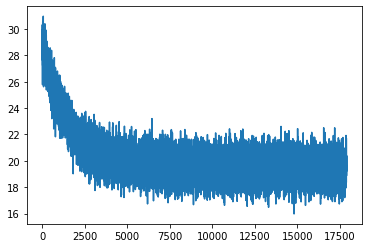

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
i = 1000 # program we are testing
task = QuantumTask(i,lambda n_qubit, program=matched_programs[i]: dc.program.Program.parse(program[0]).evaluate([])(f_no_op(n_qubit)))
code =  dc.program.Program.parse(matched_programs[i][1])
embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)
grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)


(-30.015330809014166, tensor([-17.8723], grad_fn=<AddBackward0>))

In [ ]:
print_circuit(dc.program.Program.parse(matched_programs[-100][1]).evaluate([])(no_op(4)))

          ┌───┐┌───┐┌───┐     ┌───┐     ┌───┐
q_0: ──■──┤ H ├┤ H ├┤ H ├──■──┤ H ├──■──┤ H ├
     ┌─┴─┐└───┘└───┘└───┘┌─┴─┐└───┘┌─┴─┐└───┘
q_1: ┤ X ├──■────────────┤ X ├─────┤ X ├─────
     └───┘┌─┴─┐          └───┘     └───┘     
q_2: ─────┤ X ├──────────────────────────────
          └───┘                              
q_3: ────────────────────────────────────────
                                             


In [ ]:
task = get_task_from_name("cnot_10",tasks)
code = dc.program.Program.parse("(lambda (cnot (minv(mv( $0)))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-7.783640596221253, tensor([-6.8125], grad_fn=<AddBackward0>))

In [ ]:
task = get_task_from_name("swap_01",tasks)
code = dc.program.Program.parse("(lambda  (cnot(minv(mv_r(cnot(minv (mv (cnot  $0))))))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-15.567281192442506, tensor([-15.9545], grad_fn=<AddBackward0>))

In [ ]:
task = get_task_from_name("swap_0n",tasks)
code = dc.program.Program.parse("(lambda ((  (rep (dec(dec(size $0))) (lambda ((cnot(minv(mv_r(cnot(minv (mv (cnot(mv_r $0)))))))))) )  (mv_r( (rep (dec(size $0)) (lambda (mv((cnot(minv(mv_r(cnot(minv (mv (cnot $0)))))))))) )  $0 )))))")

embedding = recognition_model.featureExtractor.featuresOfTask(task)
predicted_grammar_of_task = recognition_model(embedding)

grammar.logLikelihood(code.infer(),code), predicted_grammar_of_task.logLikelihood(code.infer(),code)

(-53.633315382926966, tensor([-53.3285], grad_fn=<AddBackward0>))

In [ ]:
task.logLikelihood(code)

0.0

In [ ]:
# Embedding should take into account values for multiple n_qubits values
# Task augmentation by merging to matched tasks
# Fix Rep problems

In [ ]:
# Problem when merging two programs: low-level programs should reset state?
# Great has strong dropout? 
# Great output shape should be fixed (independent on vertex number)


---

#### Enumerating arithmetic

In [ ]:
counter = 0
for i in iterator:
    counter +=1
    if counter<100:
        print(i)
    else: break

[(lambda 0)]


(lambda $0)
(lambda (inc $0))
(lambda (dec $0))
(lambda (inc (inc $0)))
(lambda (dec (dec $0)))
(lambda (inc (inc (inc $0))))
(lambda (dec (dec (dec $0))))
(lambda (inc (inc (inc (inc $0)))))
(lambda (dec (dec (dec (dec $0)))))
(lambda (inc (inc (inc (inc (inc $0))))))
(lambda (dec (dec (dec (dec (dec $0))))))
(lambda (inc (inc (inc (inc (inc (inc $0)))))))
(lambda (dec (dec (dec (dec (dec (dec $0)))))))
(lambda (inc (inc (inc (inc (inc (inc (inc $0))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec $0))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec $0))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0)))))))))))
(lambda (dec (dec (dec (dec (dec (dec (dec (dec (dec (dec $0)))))))))))
(lambda (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc (inc $0))))))))))))
(lambda (d